In [1]:
import BSE
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
import pprint
import pandas as pd
import seaborn as sns

from BSE import market_session

### TODO

- Design experiment
- Set up functions so it can run by itself
- Decide on best success measure
- Set up cloud services so I can run multiple experiments at once
- Mean efficiency of markets for each trader
- Tests:
    - Test 1: 1000 trials with same market
    - Tets 2: 1000 trials with different markets

In [303]:
start = 0.0
end   = 180.0
r1    = (10, 190)
r2    = (200, 300)
supply_sched = [
    {'from': start, 'to': 60, 'ranges': [r1], 'stepmode': 'fixed'},
    {'from': 60, 'to': 120, 'ranges': [r2], 'stepmode': 'fixed'},
    {'from': 120, 'to': end, 'ranges': [r1], 'stepmode': 'fixed'}
]
demand_sched = supply_sched
order_schedule = {'sup': supply_sched, 'dem': demand_sched, 
                  'interval': 30, 'timemode': 'drip-poisson'}

buyers_spec  = [('GVWY', 10), ('SHVR', 10), 
                ('ZIC', 10), ('ZIP', 10),
                ('PRDE', 10, {'k': 2, 's_min': -1, 's_max': +1, 'F': 0.8})]
sellers_spec = buyers_spec
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

In [304]:
dumpfile=open('test1data.csv', 'w')
market_session(
    'test1', start, end, traders_spec, order_schedule, dumpfile, True, True
)
dumpfile.close()

B40: PRDE active_strat=[0]:
[0]: s=+0.904796, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.944958, start=0.000000, $=0.000000, pps=0.000000


B41: PRDE active_strat=[0]:
[0]: s=-0.766805, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.061904, start=0.000000, $=0.000000, pps=0.000000


B42: PRDE active_strat=[0]:
[0]: s=+0.137810, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.001773, start=0.000000, $=0.000000, pps=0.000000


B43: PRDE active_strat=[0]:
[0]: s=-0.607241, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.091929, start=0.000000, $=0.000000, pps=0.000000


B44: PRDE active_strat=[0]:
[0]: s=+0.125497, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.452645, start=0.000000, $=0.000000, pps=0.000000


B45: PRDE active_strat=[0]:
[0]: s=+0.410800, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.470610, start=0.000000, $=0.000000, pps=0.000000


B46: PRDE active_strat=[0]:
[0]: s=+0.710001, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.157063, start=0

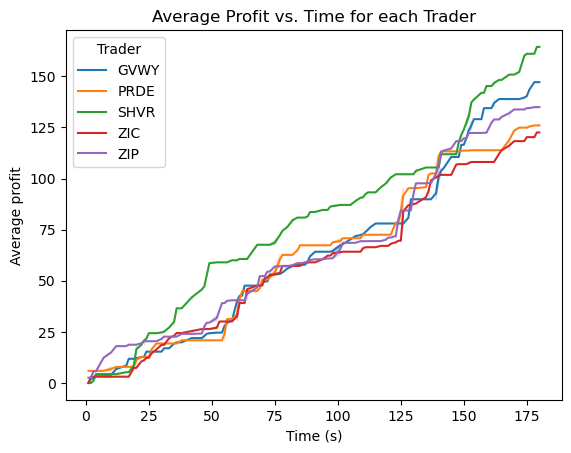

In [306]:
plot_avg_profit(read_data('test1data.csv', traders_spec))

 ----

# Helper Functions

## Custom

In [177]:
# Plots average profit for each trader
def plot_avg_profit(df, save=False, fname='figure'):
    fig, ax = plt.subplots()
    sns.lineplot(ax = ax, data=extract_avg_profit(df), dashes=False)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Average profit')
    ax.set_title('Average Profit vs. Time for each Trader')
    plt.legend(title='Trader', loc='upper left')
    if save: plt.savefig(fname)
    plt.show

In [108]:
# Plots total profit for each trader
def plot_total_profit(df, save=False, fname='figure'):
    fig, ax = plt.subplots()
    sns.lineplot(ax = ax, data=extract_total_profit(df), dashes=False)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Total profit')
    ax.set_title('Total Profit vs. Time for each Trader')
    plt.legend(title='Trader', loc='upper left')
    if save: plt.savefig(fname)
    plt.show

In [109]:
# Generates column headers
def generate_header(buyers_spec):
    header = ['trial', 'time_s', 'best_bid', 'best_offer']
    for i, _ in enumerate(buyers_spec):
        header += [f'trader{i}', f'trader{i}_total_profit', f'trader{i}_num_traders', f'trader{i}_avg_profit']
    return header

# Creates a Pandas dataframe with column headers
def read_data(path, traders_spec):
    if traders_spec['sellers'] == traders_spec['buyers']:
        header = generate_header(traders_spec['sellers'])
    df = pd.read_csv(path, usecols=range(len(header)),
                     lineterminator='\n', names=header)
    return df

In [116]:
# Creates a dataframe with only the total profits for each trader
def extract_total_profit(dataframe):
    headers = {}
    col_filter = ['time_s']
    for i, _ in enumerate(buyers_spec):
        profit = f'trader{i}_total_profit'
        col_filter += [profit]
        headers[profit] = dataframe[f'trader{i}'].iloc[0].strip(' ')
    df = dataframe[col_filter]
    df = df.rename(columns=headers)
    return df

In [122]:
# Creates a dataframe with only the average profits for each trader
def extract_avg_profit(dataframe):
    headers = {}
    col_filter = ['time_s']
    for i, _ in enumerate(buyers_spec):
        profit = f'trader{i}_avg_profit'
        col_filter += [profit]
        headers[profit] = dataframe[f'trader{i}'].iloc[0].strip(' ')
    df = dataframe[col_filter]
    df = df.rename(columns=headers)
    df = df.set_index('time_s')
    return df

## BSE

In [10]:
# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_tape.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 

# Use this to run an experiment n times and plot all trades
def n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');
    
# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()
    
# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def plot_sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# Plot sorted trades, useful is some situations
def in_order_plot(trial_id):
    prices_fname = trial_id + '_tape.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black') 

# Plot offset function
def plot_offset_fn(offset_fn, total_time_seconds):   
    x = list(range(total_time_seconds))
    offsets = []
    for i in range(total_time_seconds):
        offsets.append(offset_fn(i))
    plt.plot(x, offsets, 'x', color='black')  

# Offset Functions

In [295]:
# Step offset
def offset_step(t):
    return t // 10

def offset_sine(t):
    pi2 = math.pi * 2
    c   = math.pi * 3000
    wavelength = t / c
    gradient   = 100 * t / (c / pi2)
    amplitude  = 100 * t / (c / pi2)
    offset = gradient + amplitude * math.sin(wavelength * t)
    return int(round(offset, 0))

b           = Brownian()
random_walk = b.gen_random_walk(2000)
def offset_GBM(t):
    return (random_walk[t] * 100 // 10)

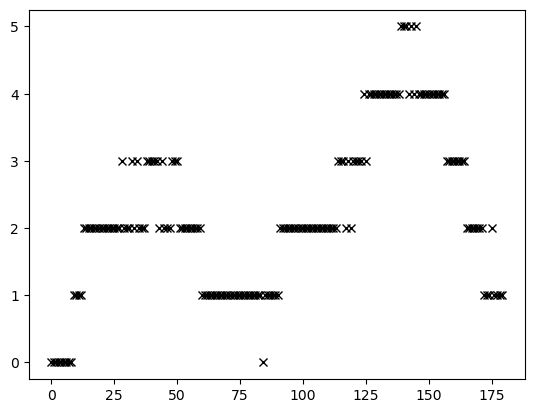

In [296]:
plot_offset_fn(offset_GBM, 180)

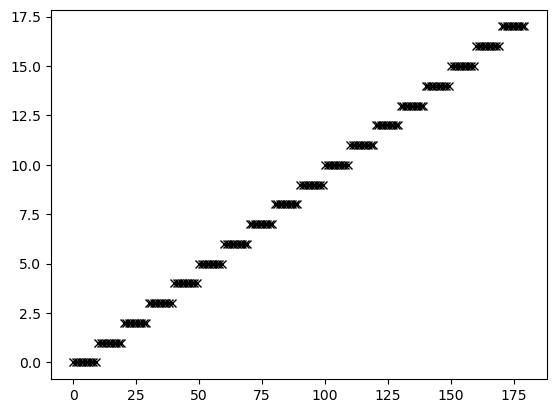

In [256]:
plot_offset_fn(offset_step, 180)

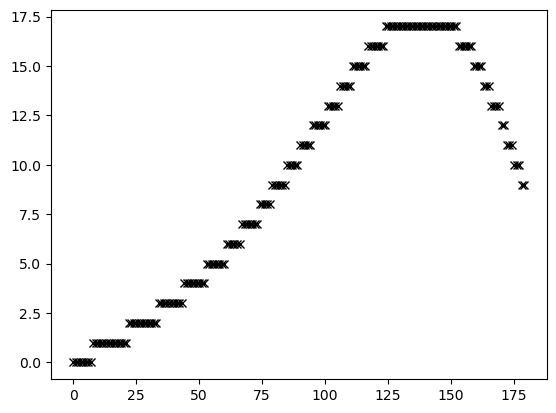

In [257]:
plot_offset_fn(offset_sine, 180)

# Geometric Brownian Motion

In [200]:
class Brownian():
    """
    A Brownian motion class constructor
    """
    def __init__(self,x0=0):
        """
        Init class
        """
        assert (type(x0)==float or type(x0)==int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
    
    def gen_random_walk(self,n_step=100):
        """
        Generate motion by random walk
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        # Warning about the small number of steps
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution with probability 1/2
            yi = np.random.choice([1,-1])
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def gen_normal(self,n_step=100):
        """
        Generate motion by drawing from the Normal distribution
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def stock_price(
                    self,
                    s0=100,
                    mu=0.2,
                    sigma=0.68,
                    deltaT=52,
                    dt=0.1
                    ):
        """
        Models a stock price S(t) using the Weiner process W(t) as
        `S(t) = S(0).exp{(mu-(sigma^2/2).t)+sigma.W(t)}`
        
        Arguments:
            s0: Iniital stock price, default 100
            mu: 'Drift' of the stock (upwards or downwards), default 1
            sigma: 'Volatility' of the stock, default 1
            deltaT: The time period for which the future prices are computed, default 52 (as in 52 weeks)
            dt (optional): The granularity of the time-period, default 0.1
        
        Returns:
            s: A NumPy array with the simulated stock prices over the time-period deltaT
        """
        n_step = int(deltaT/dt)
        time_vector = np.linspace(0,deltaT,num=n_step)
        # Stock variation
        stock_var = (mu-(sigma**2/2))*time_vector
        # Forcefully set the initial value to zero for the stock price simulation
        self.x0=0
        # Weiner process (calls the `gen_normal` method)
        weiner_process = sigma*self.gen_normal(n_step)
        # Add two time series, take exponent, and multiply by the initial stock price
        s = s0*(np.exp(stock_var+weiner_process))
        
        return s

# Order Schedules

In [183]:
fixed_supply_schedule = [{
    'from': START_TIME, 'to': END_TIME,
    'ranges': [sup_range],
    'stepmode': 'fixed'
}]

fixed_demand_schedule = [{
    'from': START_TIME, 'to': END_TIME,
    'ranges': [dem_range],
    'stepmode': 'fixed'
}]

# All traders are given a new order periodically at the same time,
# at the beginning of every interval.
fixed_periodic_order_schedule = {
    'sup'     : fixed_supply_schedule,
    'dem'     : fixed_demand_schedule,
    'interval': ORDER_INTERVAL,
    'timemode': 'periodic'
}

# Orders are given to traders one at a time at fixed intervals.
fixed_drip_fixed_order_schedule = {
    'sup'     : fixed_supply_schedule,
    'dem'     : fixed_demand_schedule,
    'interval': ORDER_INTERVAL,
    'timemode': 'drip-fixed'
}

# Similar to 'drip-fixed', but intervals are not fixed due to 
# added random noise.
fixed_drip_jitter_order_schedule = {
    'sup'     : fixed_supply_schedule,
    'dem'     : fixed_demand_schedule,
    'interval': ORDER_INTERVAL,
    'timemode': 'drip-jitter'
}

# New order arrive at intervals modelled with a Poisson distribution.
fixed_drip_poisson_order_schedule = {
    'sup'     : fixed_supply_schedule,
    'dem'     : fixed_demand_schedule,
    'interval': ORDER_INTERVAL,
    'timemode': 'drip-poisson'
}

""" All order schedules with the different types of re-supply schedules,
    using the fixed stepmode for spacing out orders.
"""
fixed_order_schedules = {
    'periodic'     : fixed_periodic_order_schedule,
    'drip-fixed'   : fixed_drip_fixed_order_schedule,
    'drip-jitter'  : fixed_drip_jitter_order_schedule,
    'drip-poisson' : fixed_drip_poisson_order_schedule
}

In [184]:
jittered_supply_schedule = [{
    'from': START_TIME, 'to': END_TIME,
    'ranges': [sup_range],
    'stepmode': 'jittered'
}]

jittered_demand_schedule = [{
    'from': START_TIME, 'to': END_TIME,
    'ranges': [dem_range],
    'stepmode': 'jittered'
}]

# All traders are given a new order periodically at the same time,
# at the beginning of every interval.
jittered_periodic_order_schedule = {
    'sup'     : jittered_supply_schedule,
    'dem'     : jittered_demand_schedule,
    'interval': ORDER_INTERVAL,
    'timemode': 'periodic'
}

# Orders are given to traders one at a time at fixed intervals.
jittered_drip_fixed_order_schedule = {
    'sup'     : jittered_supply_schedule,
    'dem'     : jittered_demand_schedule,
    'interval': ORDER_INTERVAL,
    'timemode': 'drip-fixed'
}

# Similar to 'drip-fixed', but intervals are not fixed due to 
# added random noise.
jittered_drip_jitter_order_schedule = {
    'sup'     : jittered_supply_schedule,
    'dem'     : jittered_demand_schedule,
    'interval': ORDER_INTERVAL,
    'timemode': 'drip-jitter'
}

# New order arrive at intervals modelled with a Poisson distribution.
jittered_drip_poisson_order_schedule = {
    'sup'     : jittered_supply_schedule,
    'dem'     : jittered_demand_schedule,
    'interval': ORDER_INTERVAL,
    'timemode': 'drip-poisson'
}

""" All order schedules with the different types of re-supply schedules,
    using the jittered stepmode for spacing out orders.
"""
jittered_order_schedules = {
    'periodic'     : jittered_periodic_order_schedule,
    'drip-fixed'   : jittered_drip_fixed_order_schedule,
    'drip-jitter'  : jittered_drip_jitter_order_schedule,
    'drip-poisson' : jittered_drip_poisson_order_schedule
}

In [185]:
random_supply_schedule = [{
    'from': START_TIME, 'to': END_TIME,
    'ranges': [sup_range],
    'stepmode': 'random'
}]

random_demand_schedule = [{
    'from': START_TIME, 'to': END_TIME,
    'ranges': [dem_range],
    'stepmode': 'random'
}]

# All traders are given a new order periodically at the same time,
# at the beginning of every interval.
random_periodic_order_schedule = {
    'sup'     : random_supply_schedule,
    'dem'     : random_demand_schedule,
    'interval': ORDER_INTERVAL,
    'timemode': 'periodic'
}

# Orders are given to traders one at a time at fixed intervals.
random_drip_fixed_order_schedule = {
    'sup'     : random_supply_schedule,
    'dem'     : random_demand_schedule,
    'interval': ORDER_INTERVAL,
    'timemode': 'drip-fixed'
}

# Similar to 'drip-fixed', but intervals are not fixed due to 
# added random noise.
random_drip_jitter_order_schedule = {
    'sup'     : random_supply_schedule,
    'dem'     : random_demand_schedule,
    'interval': ORDER_INTERVAL,
    'timemode': 'drip-jitter'
}

# New order arrive at intervals modelled with a Poisson distribution.
random_drip_poisson_order_schedule = {
    'sup'     : random_supply_schedule,
    'dem'     : random_demand_schedule,
    'interval': ORDER_INTERVAL,
    'timemode': 'drip-poisson'
}

""" All order schedules with the different types of re-supply schedules,
    using the random stepmode for spacing out orders.
"""
random_order_schedules = {
    'periodic'     : random_periodic_order_schedule,
    'drip-fixed'   : random_drip_fixed_order_schedule,
    'drip-jitter'  : random_drip_jitter_order_schedule,
    'drip-poisson' : random_drip_poisson_order_schedule
}